In [1]:
import torch
import numpy as np
import pandas as pd
import requests

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline, DeepAR
from pytorch_forecasting.data import GroupNormalizer

from pytorch_forecasting.metrics import PoissonLoss, QuantileLoss, SMAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
import dash

In [3]:
URL = 'https://covid.ourworldindata.org/data/owid-covid-data.json'

In [4]:
r = requests.get(URL)
data_json = r.json()

In [5]:
df = pd.DataFrame.from_dict(data_json, 'index')

In [6]:
xs = df.drop(columns='data')
raw_ys = df.data

In [7]:
xs.shape

(191, 17)

In [8]:
import matplotlib.pyplot as plt


In [9]:
nans = xs.isnull().sum()

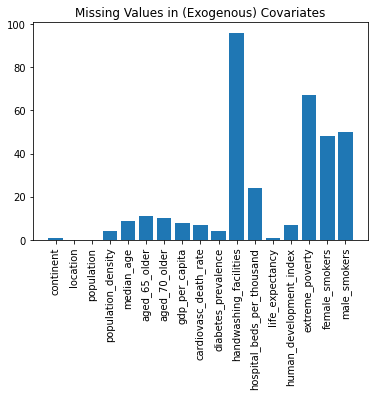

In [10]:
# look at missing values
plt.bar(nans.index.values, nans.values)
plt.title("Missing Values in (Exogenous) Covariates")
plt.xticks(rotation = 90);

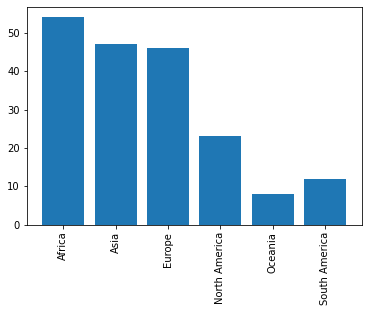

In [11]:
plt.bar(xs.groupby('continent').size().index, xs.groupby('continent').size())
plt.xticks(rotation = 90);

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


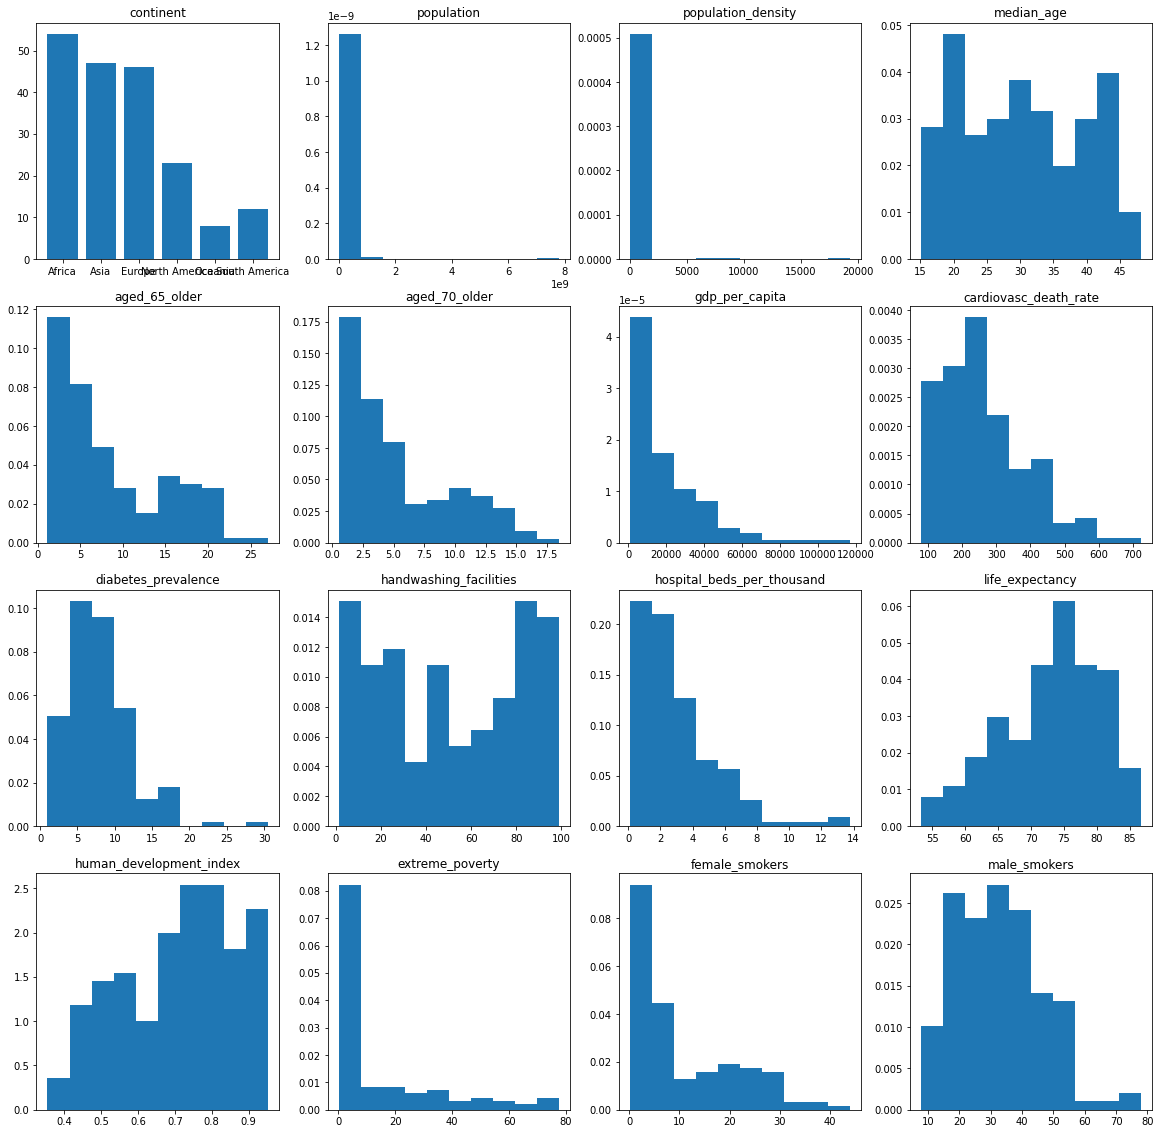

In [12]:
# plot histograms for all xs
from pandas.api.types import is_numeric_dtype

fig = plt.figure(figsize=(20,20))
# ax.set_title("Distribution of Covariates")

i = 0
for x in xs.columns:
    if(x == 'location'):
        continue
        
    i += 1
    ax = fig.add_subplot(4,4,i)
        
    if is_numeric_dtype(xs[x]):
        
        ax.set_title(x)
        ax.hist(xs[x],density=True)
    
    else:
        
        ax.bar(xs.groupby(x).size().index, xs.groupby(x).size())
        ax.set_title(x)
        
        
fig;

In [13]:
# init df with first country
ys = pd.DataFrame(raw_ys[0])
ys['location'] = raw_ys.index[0]
ys = ys.set_index('location')
ys = ys.reset_index()

# append new ones
for i in range(1,len(raw_ys)):
    new_ys = pd.DataFrame(raw_ys[i])
    new_ys['location'] = raw_ys.index[i]
    ys = ys.append(new_ys)




In [14]:
ys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61686 entries, 0 to 324
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   location                            61686 non-null  object 
 1   date                                61686 non-null  object 
 2   new_cases                           61561 non-null  float64
 3   new_deaths                          61561 non-null  float64
 4   new_cases_per_million               61561 non-null  float64
 5   new_deaths_per_million              61561 non-null  float64
 6   stringency_index                    54073 non-null  float64
 7   new_cases_smoothed                  60610 non-null  float64
 8   new_deaths_smoothed                 60610 non-null  float64
 9   new_cases_smoothed_per_million      60610 non-null  float64
 10  new_deaths_smoothed_per_million     60610 non-null  float64
 11  total_cases                         52733 n

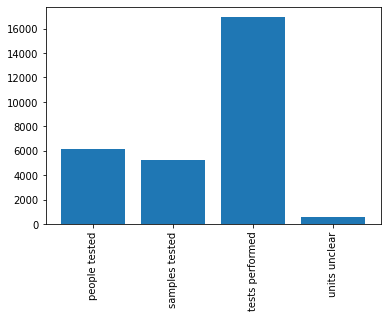

In [15]:
plt.bar(ys.groupby('tests_units').size().index, ys.groupby('tests_units').size())
plt.xticks(rotation = 90);

In [16]:
(df == 0).sum()

continent                     0
location                      0
population                    0
population_density            0
median_age                    0
aged_65_older                 0
aged_70_older                 0
gdp_per_capita                0
cardiovasc_death_rate         0
diabetes_prevalence           0
handwashing_facilities        0
hospital_beds_per_thousand    0
life_expectancy               0
human_development_index       0
data                          0
extreme_poverty               0
female_smokers                0
male_smokers                  0
dtype: int64

In [17]:
xs.columns, ys.columns

(Index(['continent', 'location', 'population', 'population_density',
        'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita',
        'cardiovasc_death_rate', 'diabetes_prevalence',
        'handwashing_facilities', 'hospital_beds_per_thousand',
        'life_expectancy', 'human_development_index', 'extreme_poverty',
        'female_smokers', 'male_smokers'],
       dtype='object'),
 Index(['location', 'date', 'new_cases', 'new_deaths', 'new_cases_per_million',
        'new_deaths_per_million', 'stringency_index', 'new_cases_smoothed',
        'new_deaths_smoothed', 'new_cases_smoothed_per_million',
        'new_deaths_smoothed_per_million', 'total_cases',
        'total_cases_per_million', 'total_deaths', 'total_deaths_per_million',
        'reproduction_rate', 'new_tests', 'total_tests',
        'total_tests_per_thousand', 'new_tests_per_thousand', 'tests_units',
        'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
        'positive_rate', 'tests_per_case

In [18]:
data = ys.join(xs, on='location',rsuffix="_x").drop(columns='location_x')

In [19]:
# should have the same number of rows
data.shape, ys.shape

((61686, 49), (61686, 33))

In [20]:
# prepare data for consumption
# generously copied from https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html for testing
# compute time index in days from t0
data['date'] = pd.to_datetime(data['date'])
t_zero = data['date'].min()
data['time_idx'] = (data['date'] - t_zero).dt.days

# fill world-level continent label
data["continent"] = data["continent"].fillna('Global')

# fill nans in test units
data["tests_units"] = data["tests_units"].fillna('NA')

# TODO: see if wwe might need additional feature
data["month"] = data.date.dt.month.astype(str).astype("category")
data["continent"] = data["continent"].astype("category")
data["tests_units"] = data["tests_units"].astype("category")


In [21]:
data.sample(10)

,location,date,new_cases,new_deaths,new_cases_per_million,new_deaths_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,...,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,extreme_poverty,female_smokers,male_smokers,time_idx,month
235,JOR,2020-09-14,214.0,2.0,20.974,0.196,61.11,150.000,1.286,14.701,...,11.75,NaN,1.40,74.53,0.735,0.1,NaN,NaN,257,9
13,VNM,2020-02-05,0.0,0.0,0.000,0.000,28.70,0.857,0.000,0.009,...,6.00,85.847,2.60,75.40,0.694,2.0,1.0,45.9,35,2
271,CHL,2020-10-20,1173.0,26.0,61.362,1.360,81.94,1456.857,43.714,76.211,...,8.46,NaN,2.11,80.18,0.843,1.3,34.2,41.5,293,10
144,GMB,2020-06-15,2.0,0.0,0.828,0.000,74.07,0.286,0.000,0.118,...,1.91,7.876,1.10,62.05,0.460,10.1,0.7,31.2,166,6
35,OWID_KOS,2020-02-27,0.0,0.0,0.000,0.000,0.00,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN,57,2
214,MNG,2020-08-24,0.0,0.0,0.000,0.000,60.19,0.000,0.000,0.000,...,4.82,71.180,7.00,69.87,0.741,0.5,5.5,46.5,236,8
123,AUS,2020-05-25,12.0,0.0,0.471,0.000,65.28,8.286,0.429,0.325,...,5.07,NaN,3.84,83.44,0.939,0.5,13.0,16.5,145,5
25,KWT,2020-02-17,0.0,0.0,0.000,0.000,5.56,0.000,0.000,0.000,...,15.84,NaN,2.00,75.49,0.803,NaN,2.7,37.0,47,2
38,GTM,2020-03-01,0.0,0.0,0.000,0.000,11.11,0.000,0.000,0.000,...,10.18,76.665,0.60,74.30,0.650,8.7,NaN,NaN,60,3
194,FIN,2020-08-04,17.0,2.0,3.068,0.361,35.19,11.286,0.286,2.037,...,5.76,NaN,3.28,81.91,0.920,NaN,18.3,22.6,216,8


In [22]:
# just take subset of European countries
# data = data[(data["continent"] == "Europe")
#                 &
#             (data["location"].isin(data["location"].sample(10)))]

In [23]:
# assign new unique index 
data.index = range(0,data.shape[0])

In [24]:
data.dtypes

location                                      object
date                                  datetime64[ns]
new_cases                                    float64
new_deaths                                   float64
new_cases_per_million                        float64
new_deaths_per_million                       float64
stringency_index                             float64
new_cases_smoothed                           float64
new_deaths_smoothed                          float64
new_cases_smoothed_per_million               float64
new_deaths_smoothed_per_million              float64
total_cases                                  float64
total_cases_per_million                      float64
total_deaths                                 float64
total_deaths_per_million                     float64
reproduction_rate                            float64
new_tests                                    float64
total_tests                                  float64
total_tests_per_thousand                     f

In [25]:
ｍax_pred_length = 7 # predict at most two weeks
max_encoder_length = 60 # use at most 2 months as input
training_cutoff = data['time_idx'].max() - max_pred_length

targets = 'new_cases'

# see https://github.com/jdb78/pytorch-forecasting/issues/187#issuecomment-743797144
# simple imputation by replacing NaNs with 0
data = data.fillna({name: 0.0 for name in ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers', targets]})


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target=targets,
    group_ids=['location'],
    min_encoder_length=int(max_encoder_length / 2),
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_pred_length,
    static_categoricals=['location', 'continent', 'tests_units'],
    static_reals = ['population','population_density','median_age','aged_65_older','aged_70_older',
                    'gdp_per_capita','cardiovasc_death_rate', 'diabetes_prevalence', 'handwashing_facilities', 
                    'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'extreme_poverty', 'female_smokers','male_smokers'],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=['time_idx', 
                              #'stringency_index', 'new_tests', unknown but could be used for conditional forecasts
                             ],
    target_normalizer=GroupNormalizer(groups=['location'], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missings=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [26]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

2173.19677734375

In [27]:
actuals

tensor([[ 235.,  234.,  210.,  ...,  135.,  202.,   63.],
        [  43.,   55.,   57.,  ...,   75.,  121.,  136.],
        [ 846.,  840.,  695.,  ...,  752.,  873.,  802.],
        ...,
        [4645., 4116., 3313.,  ..., 6709., 8166., 8319.],
        [  41.,   18.,   15.,  ...,   99.,   29.,   70.],
        [  70.,  101.,  121.,  ...,   95.,   74.,   81.]])

In [28]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=8,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 33.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 0.021379620895022322


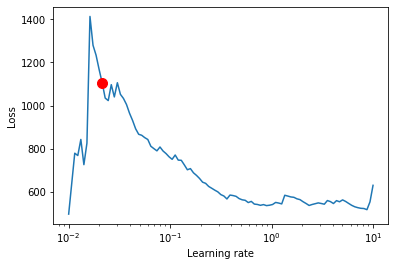

<ipython-input-29-4fb00dbde550>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [29]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-2,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [30]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.5 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Epoch 1:   2%|▏         | 8/482 [00:01<-1:59:51, -47.97it/s, loss=932.753, v_num=0, train_loss_step=617, train_loss_epoch=630]     

Finding best initial lr: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Epoch 1:   2%|▏         | 9/482 [00:02<-1:59:49, -42.92it/s, loss=940.544, v_num=0, train_loss_step=492, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Epoch 1:   2%|▏         | 10/482 [00:02<-1:59:48, -38.84it/s, loss=968.664, v_num=0, train_loss_step=1.48e+3, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]

Epoch 1:   2%|▏         | 11/482 [00:02<-1:59:46, -32.67it/s, loss=977.462, v_num=0, train_loss_step=433, train_loss_epoch=630]    

Epoch 1:   2%|▏         | 12/482 [00:02<-1:59:45, -30.26it/s, loss=984.048, v_num=0, train_loss_step=300, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Epoch 1:   3%|▎         | 13/482 [00:03<-1:59:44, -28.04it/s, loss=1018.855, v_num=0, train_loss_step=867, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 1:   3%|▎         | 14/482 [00:03<-1:59:43, -26.21it/s, loss=1026.218, v_num=0, train_loss_step=401, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 1:   3%|▎         | 15/482 [00:03<-1:59:42, -24.62it/s, loss=1042.890, v_num=0, train_loss_step=688, train_loss_epoch=630]

Finding best initial lr: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Epoch 1: 100%|█████████▉| 481/482 [01:30<00:00,  4.20it/s, loss=283.427, v_num=0, train_loss_step=308, train_loss_epoch=630]       
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 481/482 [01:34<00:00,  4.02it/s, loss=203.503, v_num=0, train_loss_step=171, train_loss_epoch=327, val_loss=1.07e+3]    
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 481/482 [01:33<00:00,  4.08it/s, loss=181.491, v_num=0, train_loss_step=216, train_loss_epoch=224, val_loss=997]    
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 481/482 [01:30<00:00,  4.23it/s, loss=253.306, v_num=0, train_loss_step=209, train_loss_epoch=219, val_loss=970]    
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 481/482 [01:31<00:00,  4.19it/s, loss=234.308, v_num=0, train_loss_step=121, train_loss_epoch=217, val_loss=1.16e+3]    
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 481/482 [01:31<00:00,  4.17it/s, loss=216.162, v_num=0, train_loss_step=184, train_loss_epoch=226, val_loss

/home/kharuto/Documents/projects/b-kaindl/udacity_new/capstone/cov_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [36]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [37]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [38]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2548.4961)

In [39]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

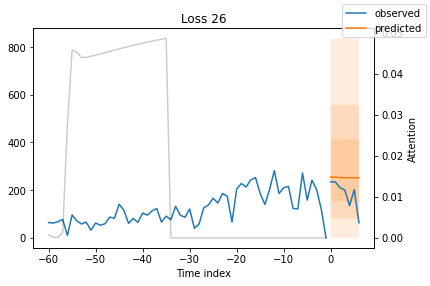

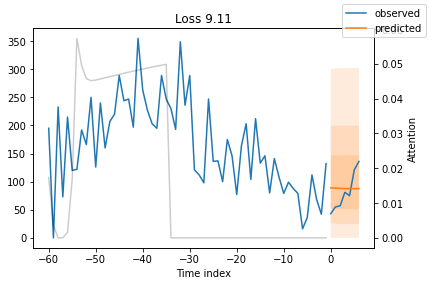

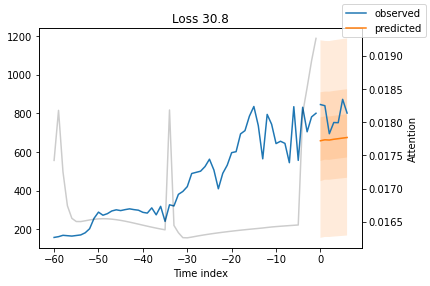

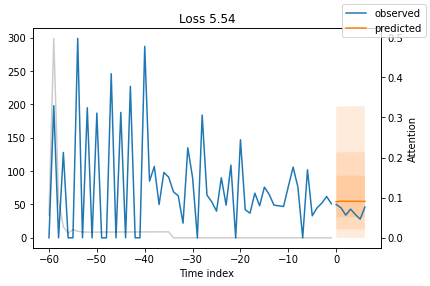

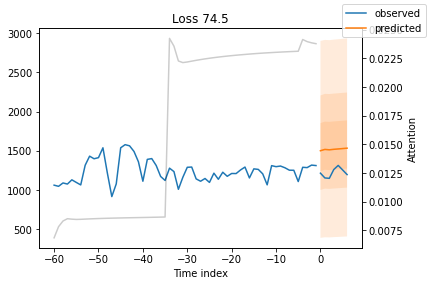

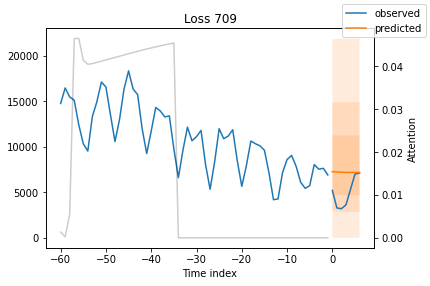

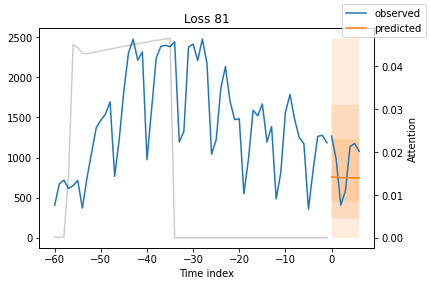

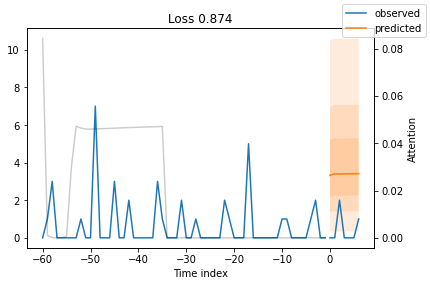

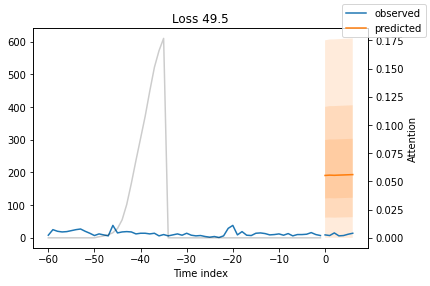

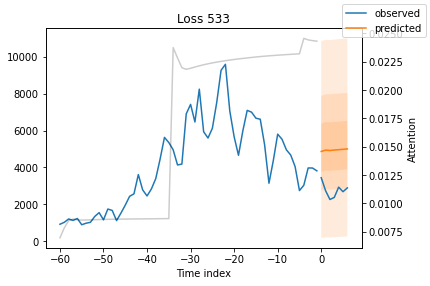

In [40]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [41]:
torch.save(best_tft.state_dict(), "20201213_tft_basemodel.pkl")